# Week 1 Assignment: Neuron Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Helper functions

In [2]:
def PlotSpikeRaster(st, y_range=[0, 1.]):
    '''
    PlotSpikeRaster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times. For example,
          spiketimes = [ np.array([0.1,0.3]), np.array([0.2,0.5,0.7]) ]
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons

    levels = np.linspace(y_range[1], y_range[0], N+1, endpoint=True)
    for n in range(N):
        nspikes = len(st[n])
        y = [ [levels[n+1]]*nspikes , [levels[n]]*nspikes ]
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim(y_range)
    plt.xlabel('Time (s)')
    return


def GenerateSpikeTrain(rates, T, jitter=0.):
    '''
    spike_times = GenerateSpikeTrain(rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    rates is an array or list of firing rates (in Hz), one
        firing rate for each interval.
    T is an array or list (the same size as 'rates') that gives
        the ending time for each interval
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    
    Example: To create a spike train of 10Hz for 0.5s, followed
             by 25Hz that starts at 0.5s and ends at 2s, use
             
               GenerateSpikeTrain([10, 25], [0.5, 2])
    '''
    s = []
    t = 0.
    for idx in range(0,len(rates)):
        Trange = T[idx] - t
        if rates[idx]!=0:
            delta = 1. / rates[idx]
            N = rates[idx] * Trange
            times = np.arange(t+delta/2., T[idx], delta)
            times += np.random.normal(scale=delta*jitter, size=np.shape(times))
            s.extend(times)
        t = T[idx]
    s.sort()
    return np.array(s)


def spikes_between(spiketrain, t_start, t_end):
    '''
     numspikes = spikes_between(spiketrain, t_start, t_end)

     Returns the number of times between t_start and t_end.
     Specifically, it counts a spike if it occurred at t, where
     t_start <= t < t_end
    
     Inputs:
       spiketrain   array-like list of spike times
       t_start      start time
       t_end        end time
       
     Output:
       numspikes    number of spikes, where t_start <= t < t_end
    '''
    sp_bool = np.logical_and( np.array(spiketrain)>=t_start, np.array(spiketrain)<t_end )
    return np.sum(sp_bool)

# Classes

## `Neuron` class
This is the base class for different types of neurons.

In [3]:
class Neuron(object):
    '''
     neur = Neuron()
     
     This is an abstract base class for Neuron objects.   
    '''
    def __init__(self):
        self.t = 0.       # current time
        self.axon = []    # list of outgoing connections
        
    def slope(self):
        return 0.
        
    def step(self, dt):
        raise NotImplementedError
        
    def send_spike(self, n=1):
        for a in self.axon:
            a.transmit(n)


## `Synapse` class
This class represents a connection between two neurons.

In [4]:
class Synapse(object):
    '''
     The Synapse class represents a connection between a pre-synaptic neuron and
     post-synaptic neuron. This class implements the presence and strength (weight)
     of the connection, but does NOT model the dynamics of the connection.
    '''
    def __init__(self, pre, post, w):
        self.pre = pre               # pre-synaptic neuron (object)
        self.post = post             # post-synaptic neuron (object)
        self.pre.axon.append(self)   # record this synapse in the pre-syn neuron
        self.w = w                   # connection weight
        
    def transmit(self, n=1):
        '''
         syn.transmit(n=1)
         
         Transmit n spikes through this synapse, from the
         pre-syn neuron to the post-syn neuron. The spikes get multiplied
         by this Synapse's connection weight.
        '''
        self.post.receive_current(n*self.w)

## `InputNeuron` class
Derived from the `Neuron` class, this class is for generating input to feed into a network.

In [5]:
class InputNeuron(Neuron):
    '''
     InputNeuron(spiketrain)

     Constructor for InputNeuron class.

     InputNeuron is a class of neuron that can be used to inject spikes into
     the network. When involved in a simulation, an InputNeuron will generate
     spikes at the times specified during its construction.

     Inputs:
       spiketrain is an array or list of spike times
    '''    
    def __init__(self, spiketrain):
        super().__init__()
        self.spikes = np.array(spiketrain)

    def step(self, slopes, dt):
        n_spikes = spikes_between(self.spikes, self.t, self.t+dt)
        self.t += dt
        if n_spikes>0:
            self.send_spike(n_spikes)


## `LIFNeuron` class
Derived from the `Neuron` class, this class implements the Leaky Integrate-and-Fire (LIF) neuron.

In [6]:
class LIFNeuron(Neuron):

    def __init__(self, Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05):
        '''
         LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)
        
         Constructor for LIFNeuron class
        
         Inputs:
           Tau_m   membrane time constant, in seconds (s)
           Tau_ref refractory period (s)
           Tau_s   synaptic time constant (s)
        '''
        super().__init__()
        # self.t and self.axon are defined in the super-class, Neuron.
        self.tau_m = Tau_m      # membrane time constant
        self.tau_ref = Tau_ref  # refractory period
        self.tau_s = Tau_s      # synaptic time constant
        self.v = 0.             # sub-threshold membrane potential (voltage)
        self.s = 0.             # post-synaptic current (PSC)
        
        self.weighted_incoming_spikes = 0.  # weighted sum of incoming spikes (for one time step)
        self.ref_remaining = 0. # amount of time remaining in the refractory period
        
        # For plotting
        self.v_history = []     # records v over time
        self.s_history = []
        self.spikes = []        # list of times when this neuron spiked
    
    def slope(self):
        '''
         LIFNeuron.slope()
        
         Evaluates the right-hand side of the differential equations that
         govern v and s.
         
         Output
          [dvdt, dsdt]  the slopes, in a list
        '''
        dvdt = ( self.s - self.v ) / self.tau_m # [1]
        dsdt = -self.s / self.tau_s  # [1]
        
        return [dvdt, dsdt]
        
        
    def step(self, slopes, dt):
        '''
         LIFNeuron.step(dt)
        
         Updates the LIF neuron state by taking an Euler step in v and s.
         The length of the step is dt seconds.
         
         Input
          slopes   list-like, containing the slopes of v and s
          dt       time step (in seconds)
          
         If v reaches the threshold of 1, the neuron fires an action potential
         (spike). Linear interpolation is used to estimate the time that v=1.
         The spike time is appended to the list self.spikes, and v
         is set to zero. After a spike, the neuron is dormant for self.tau_ref
         seconds.
        '''
        dvdt, dsdt = slopes
        # Update input current, included newly-arrived spikes
        self.s += dt*dsdt + self.weighted_incoming_spikes/self.tau_s
        
        v_previous = self.v
        t = self.t
        dt_integrate = dt
        
        # Implement refractory period
        if dt-self.ref_remaining>0:
            dt_integrate = max(0, dt-self.ref_remaining)
            t = self.t + self.ref_remaining
            self.v += dt_integrate*dvdt  # Euler step
            self.ref_remaining = 0
        else:
            self.v = 0.
            self.ref_remaining -= dt
        
        # Detect spike: if v reaches 1, spike
        if self.v>=1.0:
            # SPIKE!

            # Interpolate spike time
            v0 = v_previous
            v1 = self.v
            tstar = t + dt_integrate * (1.-v0) / (v1-v0)
            self.spikes.append(tstar)  # Record spike time

            self.v = 1.  # Set v to 1 (or zero)

            self.ref_remaining = self.tau_ref - (dt - (tstar-self.t))
            
            # Broadcast the spike to downstream neurons
            self.send_spike()

        # Store v (for plotting), and reset incoming spike accumulator
        self.v_history.append(self.v)
        self.s_history.append(self.s)
        self.weighted_incoming_spikes = 0.
        self.t += dt
        
    def receive_current(self, c):
        '''
         LIFNeuron.receive_current(c)
        
         Registers the arrival of current from a synapse. The
         member variable self.total_injected_current keeps track of all
         the incoming current for a time step.
        
         It is sufficient to add all currents together to tabulate the
         total incoming current (from all presynaptic neurons).
        
         Input:
           c    incoming current
        '''
        self.weighted_incoming_spikes += c
        
        
    def __repr__(self):
        '''
         print(neur)
         
         Prints the current time, membrane potential, input current, and
         remaining refractory time.
        '''
        return '{0:6.4f}s: s={1:5.3f}, v={2:6.4f}, ref remaining={3:7.5f}'.format(self.t, self.s, self.v, self.ref_remaining)


## `SpikingNetwork` class
This class represents a collection of neurons and their connections to each other. Add neurons, connect them, and then simulate the network.

In [7]:
class SpikingNetwork(object):
    '''
     SpikingNetwork()

     Constructor for SpikingNetwork class.

     The SpikingNetwork class contains a collection of neurons,
     and the connections between those neurons.
    '''
    def __init__(self):
        self.neur = []         # List of neurons (of various kinds)
        self.conn = []         # List of connections
        self.t_history = []    # List of time stamps for the Euler steps
                               # (Useful for plotting)
            
    def add_neuron(self, neur):
        '''
         SpikingNetwork.add_neuron(neuron)
        
         Adds a neuron to the network.
        
         Input:
           neuron is an object of type LIFNeuron or InputNeuron
        '''
        self.neur.append(neur)
        
    def connect(self, pre, post, w):
        '''
         SpikingNetwork.connect(pre, post, w)
        
         Connects neuron 'pre' to neuron 'post' with a connection
         weigth of w.
        
         where
          pre    is the pre-synaptic neuron object,
          post   is the post-synaptic neuron object, and
          weight is the connection weight.
        '''
        syn = Synapse(pre, post, w)
        self.conn.append(syn)
        
    def simulate(self, T, dt):
        '''
         SpikingNetwork.simulate(T, dt)
        
         Simulates the network for T seconds by taking Euler steps
         of size dt.
        
         Inputs:
           T    how long to integrate for
           dt   time step for Euler's method
        '''
        
        current = 0 if len(self.t_history)==0 else self.t_history[-1]
        t_segment = np.arange(current, current+T, dt)
        
        for tt in t_segment:
            self.t_history.append(tt)
            
            # Compute slopes for all neurons first...
            slopes = []
            for neur in self.neur:
                slopes.append(neur.slope())
                
            # ... then update the neurons using an Euler step.
            for neur,slope in zip(self.neur, slopes):
                neur.step(slope, dt)
                    
    def all_spike_times(self):
        '''
         SpikingNetwork.AllSpikeTimes()
        
         Returns all the spikes of all the neurons in the network.
         Useful for making spike-raster plots of network activity.
        
         Output:
           all_spikes  a list of sublists, where each sublist holds
                       the spike times of one of the neurons
        '''
        all_spikes = []
        for neur in self.neur:
            all_spikes.append(np.array(neur.spikes))
        return all_spikes

# Assignment Questions

## Q1: Two LIF Neurons

### (a)

In [8]:
# Start with network from previous question.
net = SpikingNetwork()      # Create network
A = LIFNeuron()   # Create and add LIF neurons A and B
B = LIFNeuron()
net.add_neuron(A)
net.add_neuron(B)
# Two input neurons with prescribed spike trains
InA = InputNeuron(GenerateSpikeTrain([30], [0.2]))
net.add_neuron(InA)
InB = InputNeuron(GenerateSpikeTrain([0, 90], [0.7, 0.8]))  # Input 2
net.add_neuron(InB)
# Connections
net.connect(A, B, 0.05)  # A -> B
net.connect(B, A, 0.05)  # B -> A
net.connect(InA, A, 0.05)  # InA -> A
net.connect(InB, B, -0.25) # InB -> B


### (b)

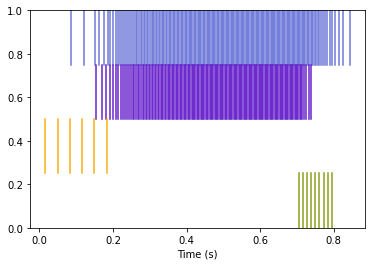

In [9]:
net.simulate(1.5, 0.001)
PlotSpikeRaster(net.all_spike_times())


### (c)
The interaction between neurons A and B is most like (b) the positive feedback you get when you place a microphone too close to its loudspeaker. The sound from the loudspeaker going into the microphone is the spikes going from A to B. And the signal picked up by the mic and being set to the loudspeaker is like the spikes going from B to A. Each element sends its signal to the other, resulting in a positive feedback loop.

(a) is incorrect because the system stabilizes (does not keep "building speed")

(c) is incorrect because the guitar string immediately decays in amplitude.


## Q2: Ring Oscillator

### (a)

In [10]:
net = SpikingNetwork()
# [1] Eight identical LIF neurons with the correct tau_s and tau_m
tau_s = 0.1
tau_m = 0.05
A = LIFNeuron(Tau_s=tau_s, Tau_m=tau_m); net.add_neuron(A)
B = LIFNeuron(Tau_s=tau_s, Tau_m=tau_m); net.add_neuron(B)
C = LIFNeuron(Tau_s=tau_s, Tau_m=tau_m); net.add_neuron(C)
D = LIFNeuron(Tau_s=tau_s, Tau_m=tau_m); net.add_neuron(D)
E = LIFNeuron(Tau_s=tau_s, Tau_m=tau_m); net.add_neuron(E)
F = LIFNeuron(Tau_s=tau_s, Tau_m=tau_m); net.add_neuron(F)
G = LIFNeuron(Tau_s=tau_s, Tau_m=tau_m); net.add_neuron(G)
H = LIFNeuron(Tau_s=tau_s, Tau_m=tau_m); net.add_neuron(H)
# [1] Connections for excitatory ring
w = 0.2
net.connect(A, B, w)
net.connect(B, C, w)
net.connect(C, D, w)
net.connect(D, E, w)
net.connect(E, F, w)
net.connect(F, G, w)
net.connect(G, H, w)
net.connect(H, A, w)  # close loop


### (b)

In [11]:
# Connections for inhibitory ring
w = -2*w
net.connect(B, A, w)
net.connect(C, B, w)
net.connect(D, C, w)
net.connect(E, D, w)
net.connect(F, E, w)
net.connect(G, F, w)
net.connect(H, G, w)
net.connect(A, H, w)


### (c)

In [12]:
# Create and connect input neuron
# Can be connected to any neuron in the ring.
input_neuron = InputNeuron(GenerateSpikeTrain([25], [0.3]))
net.add_neuron(input_neuron)
net.connect(input_neuron, A, 0.2) # Seed one element in the ring


### (d)

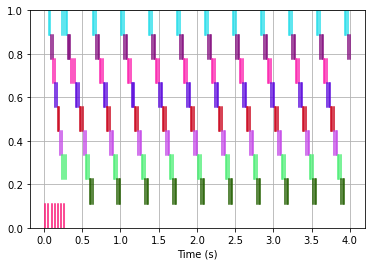

In [13]:
# Simulate and Plot spike rasters
net.simulate(4., 0.001)
PlotSpikeRaster(net.all_spike_times());
plt.grid('on');  # this grid command is not necessary


### (e)

Judging by the fact that we see 9 periods between 0.6 and 3.9 seconds, the period must be around $\frac{3.9-0.6}{9}$ or 0.37 seconds.

**For the sake of grading, we will also accept the reciprocal of that answer, which gives 2.7 Hz (cycles per second).**


In [14]:
print((3.9-0.6)/9)


0.36666666666666664
